In [2]:
import cv2
import glob
import pickle
import scipy.io
import scipy.stats
import numpy as np
import pandas as pd
import mediapipe as mp
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

## Data Pipeline

Num of images:  2000
Image shape:  (450, 450, 3)


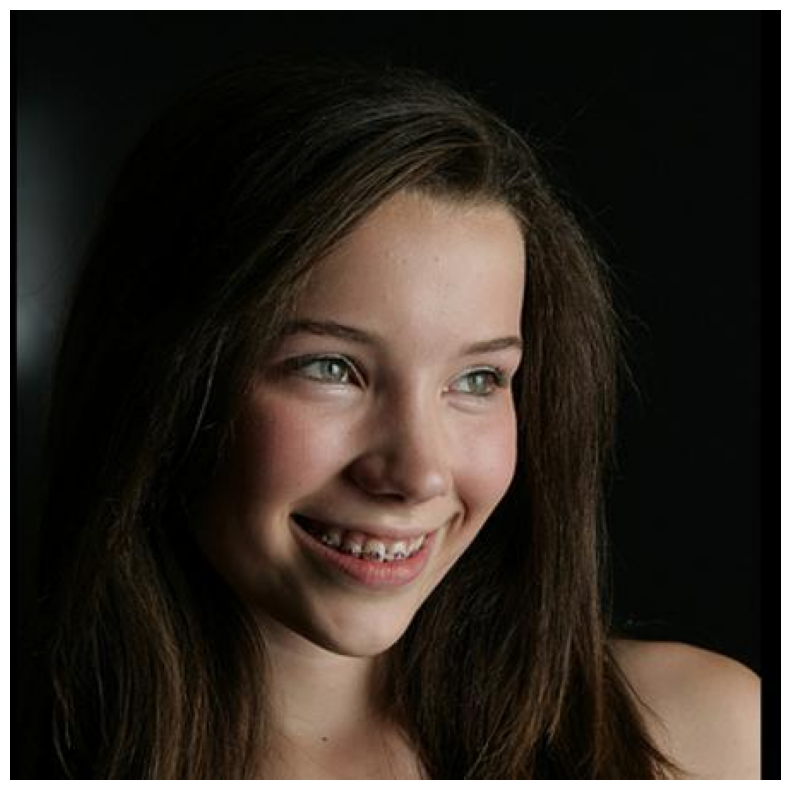

In [2]:
DEMO_IMG_NUMBER = 805

images_paths = glob.glob('data/AFLW2000/*.jpg')
print('Num of images: ', len(images_paths))

img = cv2.imread(images_paths[DEMO_IMG_NUMBER])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print('Image shape: ', img.shape)
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(img);

In [3]:
img_info_paths = glob.glob('data/AFLW2000/*.mat')
mat = scipy.io.loadmat(img_info_paths[DEMO_IMG_NUMBER])
mat['Pose_Para'][0][:3]  # Extracting pitch, yaw, and roll

array([-0.31531143, -0.33785677,  0.1856054 ], dtype=float32)

c:\Users\isuru\anaconda3\envs\uni\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


nose position:  (244.2385733127594, 283.98174941539764)


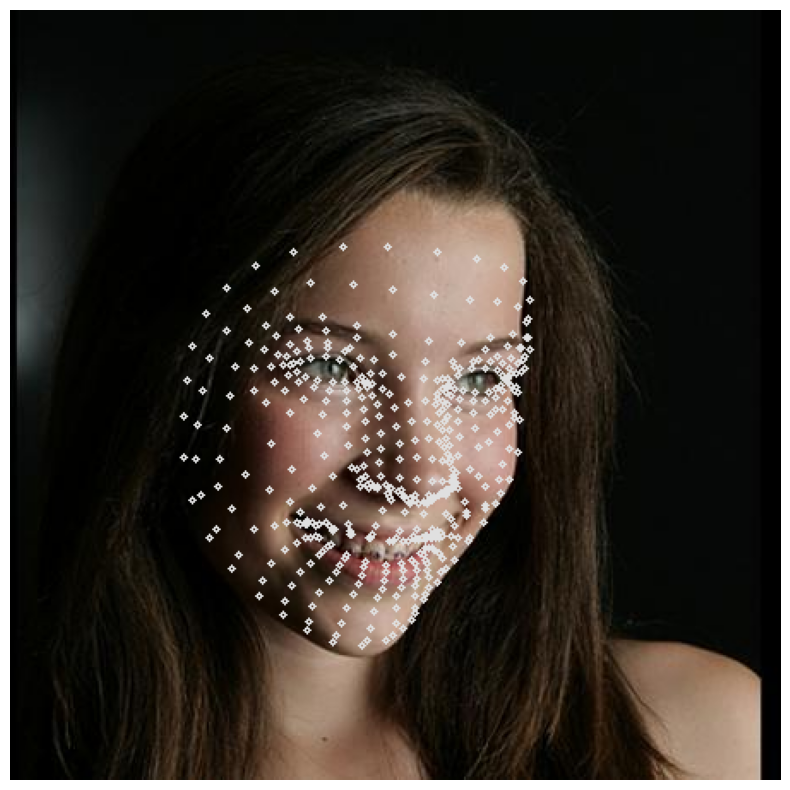

In [4]:
face_mesh = mp.solutions.face_mesh.FaceMesh(
                                            min_detection_confidence=0.5, 
                                            min_tracking_confidence=0.5
                                            )
drawing_specs = mp.solutions.drawing_utils.DrawingSpec(thickness=1, circle_radius=1)
result = face_mesh.process(img)

img_h, img_w, img_c = img.shape
annot_img = img.copy()

if result.multi_face_landmarks != None:
    for face_landmarks in result.multi_face_landmarks:        
        mp.solutions.drawing_utils.draw_landmarks(
                                                    image=annot_img, 
                                                    landmark_list=face_landmarks, 
                                                    landmark_drawing_spec=drawing_specs
                                                    )
        for idx, lm in enumerate(result.multi_face_landmarks[0].landmark):
            if idx == 1:
                nose_x = lm.x * img_w
                nose_y = lm.y * img_h

print('nose position: ', (nose_x, nose_y))
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(annot_img);

In [5]:
cols = []
for pos in ['nose_', 'forehead_', 'left_eye_', 'mouth_left_', 'chin_', 'right_eye_', 'mouth_right_']:
    for dim in ('x', 'y'):
        cols.append(pos+dim)
cols.extend(['pitch', 'yaw', 'roll'])

In [6]:
def extract_features(
                    img, face_mesh, 
                    NOSE = 1,
                    CHIN = 199,
                    FOREHEAD = 10,
                    LEFT_EYE = 33,
                    RIGHT_EYE = 263,
                    MOUTH_LEFT = 61,
                    MOUTH_RIGHT = 291,
                    mat=None
                    ):
    result = face_mesh.process(img)
    face_features = []

    if result.multi_face_landmarks != None:
        for face_landmarks in result.multi_face_landmarks:
            for idx, lm in enumerate(face_landmarks.landmark):
                if idx in [FOREHEAD, NOSE, MOUTH_LEFT, MOUTH_RIGHT, CHIN, LEFT_EYE, RIGHT_EYE]:
                    face_features.append(lm.x)
                    face_features.append(lm.y)
    else:
        face_features.extend([None] * 14)
    
    if mat:
        pose_angles = mat['Pose_Para'][0][:3]
        face_features.extend(pose_angles)
        
    return face_features

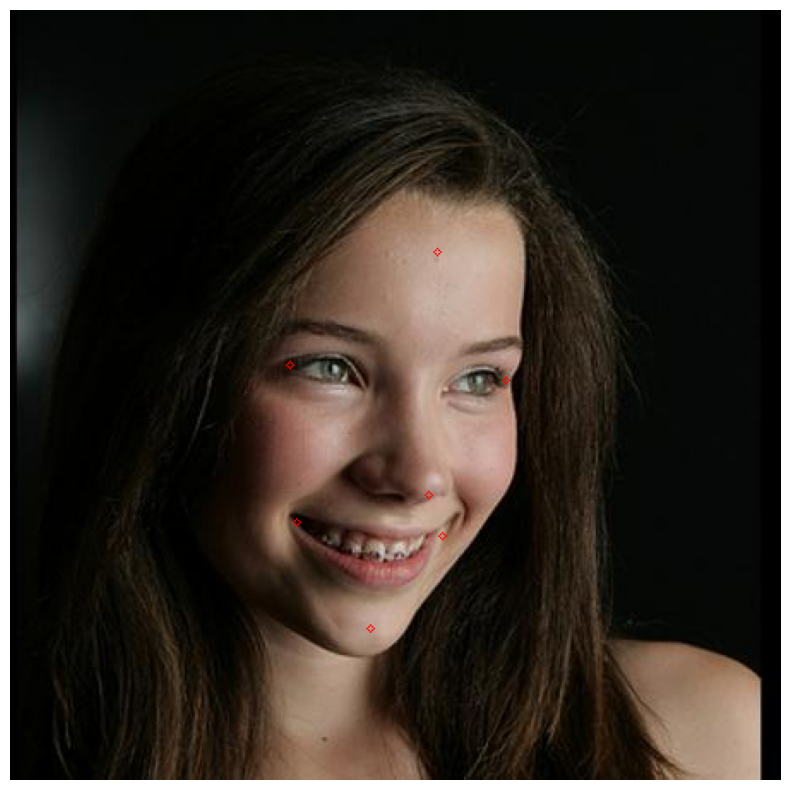

In [7]:
face_mesh = mp.solutions.face_mesh.FaceMesh(
                                            min_detection_confidence=0.5, 
                                            min_tracking_confidence=0.5
                                            )
s = extract_features(img, face_mesh)
annot_img = img.copy()

for i in range(len(s)//2):
        cv2.circle(annot_img, center=[int(s[i*2]*img_w), int(s[i*2+1]*img_h)], radius=2, color=(255, 0, 0))
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(annot_img);

In [8]:
face_mesh = mp.solutions.face_mesh.FaceMesh(
                                            min_detection_confidence=0.5, 
                                            min_tracking_confidence=0.5
                                            )
poses = []

for img_idx, img_path in enumerate(images_paths):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mat = scipy.io.loadmat(img_info_paths[img_idx])

    try:
        face_features = extract_features(img, face_mesh, mat=mat)
        poses.append(face_features)
    except:
        print("     Skipping image ", img_idx)

    if img_idx % 100 == 0:
        print('Extracted images: ', img_idx)

poses_df = pd.DataFrame(poses, columns=cols)

Extracted images:  0
Extracted images:  100
Extracted images:  200
Extracted images:  300
Extracted images:  400
Extracted images:  500
Extracted images:  600
Extracted images:  700
Extracted images:  800
Extracted images:  900
Extracted images:  1000
Extracted images:  1100
Extracted images:  1200
Extracted images:  1300
Extracted images:  1400
Extracted images:  1500
Extracted images:  1600
Extracted images:  1700
Extracted images:  1800
Extracted images:  1900


In [9]:
print(poses_df.head())
poses_df.to_csv('data/AFLW2000/poses.csv', index=False)

     nose_x    nose_y  forehead_x  forehead_y  left_eye_x  left_eye_y  \
0  0.489194  0.639722    0.521101    0.295806    0.354743    0.441597   
1  0.401499  0.604184    0.475316    0.344523    0.408574    0.481754   
2  0.445534  0.621876    0.443547    0.373616    0.424176    0.508653   
3  0.467992  0.648420    0.407912    0.370758    0.354222    0.524016   
4  0.372060  0.621196    0.395060    0.392921    0.397376    0.513964   

   mouth_left_x  mouth_left_y    chin_x    chin_y  right_eye_x  right_eye_y  \
0      0.403753      0.680927  0.481321  0.807920     0.669544     0.473942   
1      0.421570      0.668330  0.447475  0.764491     0.605816     0.506940   
2      0.480120      0.683903  0.528819  0.769280     0.586251     0.500861   
3      0.463581      0.699305  0.551854  0.780015     0.605186     0.467229   
4      0.433618      0.697691  0.467873  0.773994     0.525802     0.498256   

   mouth_right_x  mouth_right_y     pitch       yaw      roll  
0       0.574203      

## Model Training

In [10]:
poses_df = pd.read_csv('data/AFLW2000/poses.csv')
poses_df = poses_df.dropna(axis=0)
poses_df

,nose_x,nose_y,forehead_x,forehead_y,left_eye_x,left_eye_y,mouth_left_x,mouth_left_y,chin_x,chin_y,right_eye_x,right_eye_y,mouth_right_x,mouth_right_y,pitch,yaw,roll
0,0.489194,0.639722,0.521101,0.295806,0.354743,0.441597,0.403753,0.680927,0.481321,0.807920,0.669544,0.473942,0.574203,0.702994,-0.399231,0.018227,0.085676
1,0.401499,0.604184,0.475316,0.344523,0.408574,0.481754,0.421570,0.668330,0.447475,0.764491,0.605816,0.506940,0.523344,0.691370,0.470065,1.189533,0.300959
2,0.445534,0.621876,0.443547,0.373616,0.424176,0.508653,0.480120,0.683903,0.528819,0.769280,0.586251,0.500861,0.582848,0.679839,-0.184650,0.881137,-0.236852
3,0.467992,0.648420,0.407912,0.370758,0.354222,0.524016,0.463581,0.699305,0.551854,0.780015,0.605186,0.467229,0.604576,0.666296,-0.175379,0.299208,-0.373374
4,0.372060,0.621196,0.395060,0.392921,0.397376,0.513964,0.433618,0.697691,0.467873,0.773994,0.525802,0.498256,0.508779,0.698543,-0.882169,1.198004,-1.033374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,0.534162,0.623934,0.518754,0.312075,0.349057,0.485040,0.424038,0.697132,0.499427,0.788211,0.635844,0.481809,0.570497,0.690742,-0.306358,-0.283822,0.038554
1992,0.569275,0.632902,0.562170,0.318961,0.386851,0.474827,0.442935,0.697338,0.522094,0.801679,0.665542,0.476053,0.592680,0.695240,-0.367547,-0.429723,0.122791
1994,0.604407,0.627700,0.664646,0.387628,0.503506,0.485360,0.507515,0.689498,0.547061,0.793431,0.736257,0.551269,0.645251,0.724783,-0.156035,0.567114,-0.108536
1995,0.486602,0.624109,0.522991,0.301004,0.354324,0.441646,0.412282,0.681156,0.483026,0.786989,0.680817,0.491351,0.567541,0.702234,-0.197102,-0.070430,0.105118


In [11]:
train_df, val_df = train_test_split(poses_df, test_size=0.2, random_state=42)

X_train = train_df.drop(['pitch', 'yaw', 'roll'], axis=1)
y_train = train_df[['pitch', 'yaw', 'roll']]

X_val = val_df.drop(['pitch', 'yaw', 'roll'], axis=1)
y_val = val_df[['pitch', 'yaw', 'roll']]

In [12]:
param_grid = {
            'estimator__kernel': ['linear', 'poly', 'rbf'],
            'estimator__C': scipy.stats.expon(scale=5),
            'estimator__degree': np.arange(2, 6),
            'estimator__coef0': np.arange(0, 6),
            'estimator__gamma': scipy.stats.expon(scale=.1),
            'estimator__epsilon': scipy.stats.expon(scale=.1)
            }

svr = SVR()
multi_out_svr = MultiOutputRegressor(svr)
random_search = RandomizedSearchCV(
                                    multi_out_svr, 
                                    param_grid, 
                                    scoring='neg_mean_squared_error', 
                                    random_state=42
                                    )
random_search.fit(X_train, y_train)
svr_model = random_search.best_estimator_

print('best parameters: ', random_search.best_params_)
print('train_rmse: ', np.sqrt(-random_search.best_score_))
print('validation_rmse: ', np.sqrt(mean_squared_error(y_val, svr_model.predict(X_val))))

best parameters:  {'estimator__C': 5.748425702439672, 'estimator__coef0': 3, 'estimator__degree': 2, 'estimator__epsilon': 0.17909292843438934, 'estimator__gamma': 0.01903916165167499, 'estimator__kernel': 'linear'}
train_rmse:  0.225613486909032
validation_rmse:  0.1708914963616808


In [13]:
param_grid = {
            'estimator__kernel': ['rbf'],
            'estimator__C': np.arange(0.6, 0.75, 0.01),
            'estimator__gamma': np.arange(0.09, 0.1, 0.001),
            'estimator__epsilon': np.arange(0.07, 0.08, 0.001)
            }

svr = SVR()
multi_out_svr = MultiOutputRegressor(svr)
grid_search = GridSearchCV(
                            multi_out_svr, 
                            param_grid, 
                            scoring='neg_mean_squared_error'
                            )
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_

print('best parameters: ', grid_search.best_params_)
print('train_rmse: ', np.sqrt(-grid_search.best_score_))
print('validation_rmse: ', np.sqrt(mean_squared_error(y_val, model.predict(X_val))))

best parameters:  {'estimator__C': 0.7500000000000001, 'estimator__epsilon': 0.07, 'estimator__gamma': 0.1, 'estimator__kernel': 'rbf'}
train_rmse:  0.26876627914606976
validation_rmse:  0.20636134098933115


In [14]:
pickle.dump(model, open('models/head_pose.pkl', 'wb'))

### Model Inference

In [1]:
import cv2
import glob
import time
import pickle
import scipy.stats
import numpy as np
import pandas as pd
import mediapipe as mp

In [2]:
# with open('models/head_pose.pkl', 'rb') as f:
#     model_head_pose = pickle.load(f)

face_mesh = mp.solutions.face_mesh.FaceMesh(
                                            min_detection_confidence=0.5, 
                                            min_tracking_confidence=0.5
                                            )

mp_drawing = mp.solutions.drawing_utils
drawing_spec = mp_drawing.DrawingSpec(
                                    color=(128,0,128),
                                    circle_radius=1,
                                    thickness=2
                                    )
p_face_mesh = mp.solutions.face_mesh

In [2]:
print("Mediapipe version: ", mp.__version__)

Mediapipe version:  0.10.14


In [ ]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    success, image = cap.read()
  
    start = time.time()

    image = cv2.cvtColor(cv2.flip(image,1),cv2.COLOR_BGR2RGB) #flipped for selfie view

    image.flags.writeable = False

    results = face_mesh.process(image)

    image.flags.writeable = True

    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)

    img_h , img_w, img_c = image.shape
    face_2d = []
    face_3d = []

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            for idx, lm in enumerate(face_landmarks.landmark):
                if idx == 33 or idx == 263 or idx ==1 or idx == 61 or idx == 291 or idx==199:
                    if idx ==1:
                        nose_2d = (lm.x * img_w,lm.y * img_h)
                        nose_3d = (lm.x * img_w,lm.y * img_h,lm.z * 3000)
                    x,y = int(lm.x * img_w),int(lm.y * img_h)

                    face_2d.append([x,y])
                    face_3d.append(([x,y,lm.z]))


            #Get 2d Coord
            face_2d = np.array(face_2d,dtype=np.float64)

            face_3d = np.array(face_3d,dtype=np.float64)

            focal_length = 1 * img_w

            cam_matrix = np.array([[focal_length,0,img_h/2],
                                  [0,focal_length,img_w/2],
                                  [0,0,1]])
            distortion_matrix = np.zeros((4,1),dtype=np.float64)

            success,rotation_vec,translation_vec = cv2.solvePnP(face_3d,face_2d,cam_matrix,distortion_matrix)


            #getting rotational of face
            rmat,jac = cv2.Rodrigues(rotation_vec)

            angles,mtxR,mtxQ,Qx,Qy,Qz = cv2.RQDecomp3x3(rmat)

            x = angles[0] * 360
            y = angles[1] * 360
            z = angles[2] * 360

            #here based on axis rot angle is calculated
            if y < -10:
                text="Looking Left"
            elif y > 10:
                text="Looking Right"
            elif x < -10:
                text="Looking Down"
            elif x > 10:
                text="Looking Up"
            else:
                text="Forward"

            nose_3d_projection,jacobian = cv2.projectPoints(nose_3d,rotation_vec,translation_vec,cam_matrix,distortion_matrix)

            p1 = (int(nose_2d[0]),int(nose_2d[1]))
            p2 = (int(nose_2d[0] + y*10), int(nose_2d[1] -x *10))

            cv2.line(image,p1,p2,(255,0,0),3)

            cv2.putText(image,text,(20,50),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),2)
            cv2.putText(image,"x: " + str(np.round(x,2)),(500,50),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)
            cv2.putText(image,"y: "+ str(np.round(y,2)),(500,100),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)
            cv2.putText(image,"z: "+ str(np.round(z, 2)), (500, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)


        end = time.time()
        totalTime = end - start
        # Prevent division by zero
        if totalTime > 0:
            fps = 1 / totalTime
        else:
            fps = 0  # Set FPS to 0 if totalTime is zero or too small
        print("FPS: ",fps)
        cv2.putText(image, f'FPS: {int(fps)}', (20, 450), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 2)

        mp_drawing.draw_landmarks(
                                image=image,
                                landmark_list=face_landmarks,
                                connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
                                connection_drawing_spec=drawing_spec,
                                landmark_drawing_spec=drawing_spec
                                )
    cv2.imshow('Head Pose Detection',image)
    if cv2.waitKey(5) & 0xFF ==27:
        break
cap.release()


c:\Users\moham\anaconda3\envs\elarning\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


FPS:  15.368817558902203
FPS:  0
FPS:  0
FPS:  212.96288398070575
FPS:  211.53439580391367
FPS:  176.76601483479433
FPS:  249.83940910173934
FPS:  150.9611287071696
FPS:  200.12901994465122
FPS:  237.9476938787088
FPS:  0
FPS:  0
FPS:  0
FPS:  251.9555475461044
FPS:  0
FPS:  197.4719397363465
FPS:  0
FPS:  0
FPS:  0
FPS:  1573.8476547842401
FPS:  249.67581403654978
FPS:  0
FPS:  912.7973884657237
FPS:  0
FPS:  0
FPS:  609.106012198664
FPS:  212.03700520701685
FPS:  240.7752009184845
FPS:  194.351698253093
FPS:  0
FPS:  0
FPS:  0
FPS:  214.75111361425425
FPS:  250.24187101008292
FPS:  63.937560975609756
FPS:  0
FPS:  0
FPS:  249.18631178707224
FPS:  0
FPS:  621.3783703703704
FPS:  203.35033452923494
FPS:  0
FPS:  245.45318352059925
FPS:  746.4502580530343
FPS:  0
FPS:  0
FPS:  0
FPS:  250.01812112541725
FPS:  77.12669633334559
FPS:  498.1950350397909
FPS:  0
FPS:  0
FPS:  0
FPS:  268.79671879005383
FPS:  0
FPS:  0
FPS:  0
FPS:  331.56553359683795
FPS:  1981.248937175248
FPS:  0
FPS:  26